# Subpixel Accuracy and Uncertainty Estimation

## How is subpixel resolution possible?

Tracking resolution can exceed the traditional diffraction-limited resolution of a microscope. If a particle's image spans multiple pixels, we can find its position with subpixel accuracy by taking the average position of these pixels, weighted by brightness. This is referred to as the particle's *centroid*.

This tutorial will use simulated images to demonstrate how well trackpy's implementation of the Crocker--Grier algorithm determines particle locations under various conditions. It also demonstrates trackpy's uncertainty-estimation capability and introduces the most important sources of error in particle tracking experiments.

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import trackpy as tp
import pims

# optional, just for plot style:
mpl.style.use('http://tiny.cc/leheny-style-sans-serif/raw') 

## Demonstration of trackpy's uncertainty estimation on noisy images

We'll draw a simulated image with a single Gaussian blob. The class below will make it easy to generate copies of the images with simulated camera noise.

In [2]:
class SimulatedFrame(object):
    
    def __init__(self, shape, dtype=np.uint8):
        self.image = np.zeros(shape, dtype=dtype)
        self._saturation = np.iinfo(dtype).max
        self.shape = shape
        self.dtype =dtype
        
    def add_spot(self, pos, amplitude, r, ecc=0):
        "Add a Gaussian spot to the frame."
        x, y = np.meshgrid(*np.array(list(map(np.arange, self.shape))) - np.asarray(pos))
        spot = amplitude*np.exp(-((x/(1 - ecc))**2 + (y*(1 - ecc))**2)/(2*r**2)).T
        self.image += np.clip(spot, 0, self._saturation).astype(self.dtype)
        
    def with_noise(self, noise_level, seed=0):
        "Return a copy with noise."
        rs = np.random.RandomState(seed)
        noise = rs.randint(-noise_level, noise_level, self.shape)
        noisy_image = np.clip(self.image + noise, 0, self._saturation).astype(self.dtype)
        return noisy_image
    
    def add_noise(self, noise_level, seed=0):
        "Modify in place with noise."
        self.image = self.with_noise(noise_level, seed=seed)

The uncertainty in particle location can be estimated from the radius of gyration, the mask size (i.e., `diameter` specified to `locate()`) and the signal-to-noise ratio. The relation was worked out in a [detailed study of particle tracking errors by Savin and Doyle](http://dx.doi.org/10.1529/biophysj.104.042457). For a hat-like spot, the uncertainty in location of a hat-like spot is

$$\epsilon = \frac{N}{S}\frac{l_\text{noise}}{2\pi^{1/2}}\frac{w^2}{a^2}$$

where $N/S$ is noise-to-signal; $l_n$=1 pixel, the length scale of noise correlation; and $w$ and $a$ are feature size and mask size respectively. (The uncertainty in the location of a Gaussian blob is similar and more computationally intensive.)

Trackpy performs the computation and gives the results in the `'ep'` column of the results set returned by `locate` or `batch`. This can be used as an estimate of uncertainty.

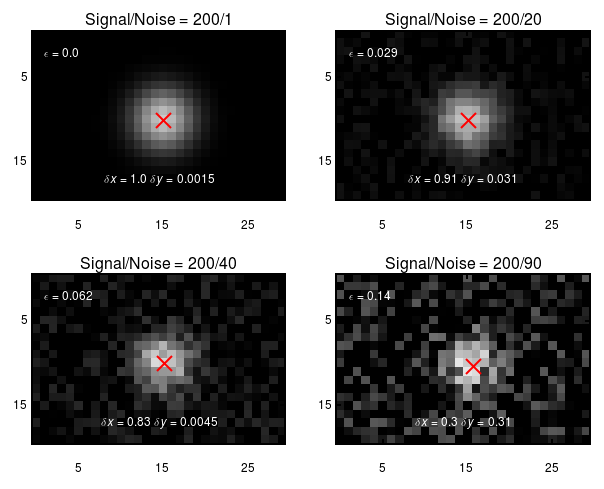

In [3]:
fig, axes = plt.subplots(2, 2)

frame = SimulatedFrame((20, 30))
frame.add_spot((10, 15), 200, 2.5)

for ax, noise_level in zip(axes.ravel(), [1, 20, 40, 90]):
    noisy_copy = frame.with_noise(noise_level)
    features = tp.locate(noisy_copy, 13, topn=1, engine='python')
    tp.annotate(features, noisy_copy, plot_style=dict(marker='x'), imshow_style=dict(vmin=0, vmax=255), ax=ax)
    dx, dy, ep = features[['x', 'y', 'ep']].iloc[0].values - [16, 10, 0]
    ax.set(xticks=[5, 15, 25], yticks=[5, 15])
    ax.set(title=r'Signal/Noise = {signal}/{noise}'.format(
              signal=200, noise=noise_level))
    ax.text(0.5, 0.1, r'$\delta x={dx:.2}$  $\delta y={dy:.2}$'.format(
                dx=abs(dx), dy=abs(dy)), ha='center', color='white', transform=ax.transAxes)
    ax.text(0.05, 0.85, r'$\epsilon={ep:.2}$'.format(ep=abs(ep)), ha='left', color='white',
            transform=ax.transAxes)
fig.subplots_adjust()

## The effect of `diameter` on precision

The size of the feature, as specified in the call to the `locate` function, has an important effect of the precision. If a user underestimates the particle's diameter, precision suffers. Thus, it is best to err on the high side, although this a larger diameter comes at some cost in performance.

As demonstrated below, a too-small `diameter` often biases the location toward the pixel edges.

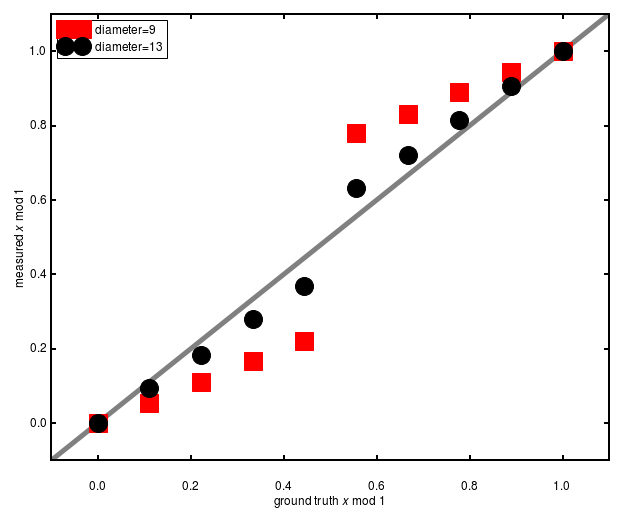

In [4]:
good_results = []
bad_results = []
steps = np.linspace(0, 1, num=10, endpoint=True)

for s in steps:
    frame = SimulatedFrame((20, 30))
    frame.add_spot((10, 15 + s), 200, 2.5)
    feature = tp.locate(frame.image, 13, topn=1, preprocess=False, engine='python')
    good_results.append(feature)
    feature = tp.locate(frame.image, 9, topn=1, preprocess=False, engine='python')
    bad_results.append(feature)
    
good_df = pd.DataFrame([pd.concat(good_results)['x'].reset_index(drop=True) - 15, pd.Series(steps, name='true x')]).T
bad_df = pd.DataFrame([pd.concat(bad_results)['x'].reset_index(drop=True) - 15, pd.Series(steps, name='true x')]).T

fig, ax = plt.subplots()
ax.plot([-0.1, 1.1], [-0.1, 1.1], color='gray')
ax.plot(bad_df['true x'], bad_df['x'], marker='s', lw=0, mfc='r', mec='r', mew=1, label='diameter=9')
ax.plot(good_df['true x'], good_df['x'], marker='o', lw=0, mfc='k', mec='k', mew=1, label='diameter=13')
ax.set(xlabel=r'ground truth $x$ mod 1', ylabel=r'measured $x$ mod 1')
ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
ax.legend(loc='best');

## How tracking errors can qualitatively affect physical interpretation

Random errors in particle tracking can lead to systematic errors in the derived statistics, such as mean squared displacement, that are qualitatively misleading. The nature of the distortion depends on the particulars of the experiment. For simple Brownian diffusion---a random walk---random errors in locating a particle add a constant offset to the mean squared displacement, $\langle \Delta r^2\rangle$. This and other cases are derived in detail in [the paper by Savin and Doyle](http://dx.doi.org/10.1529/biophysj.104.042457).

In [5]:
N = 10000
traj = pd.DataFrame(np.random.randn(N, 2).cumsum(0), columns=['x', 'y'])
noisy_traj = traj + np.random.randn(N, 2)
traj['frame'] = np.arange(N)
noisy_traj['frame'] = np.arange(N)

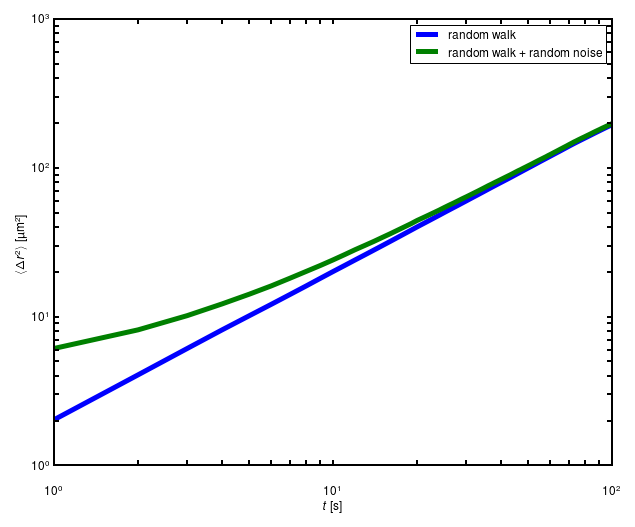

In [6]:
fig, ax = plt.subplots()
ax.plot(tp.msd(traj, 1, 1)['msd'], label='random walk')
ax.plot(tp.msd(noisy_traj, 1, 1)['msd'], label='random walk + random noise')
ax.legend()
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$t$ [s]', ylabel=r'$\langle \Delta r^2 \rangle$ [\textmu m$^2$]');